# Statistics for Biologists
This notebook will discuss **descriptive** and **inferential** statistics, and introduce ways to implement them in Python.

### By the end of this notebook, you will be able to:
* Identify when to use descriptive or inferential statistics
* Apply the appropriate statistical tests to compare two groups
* Use the stats package from SciPy to run simple tests in Python
* Test direction selectivity differences in two Brain Observatory cell types

### Table of Contents
1. [Part One: Population vs sample distributions](#one)
2. [Part Two: The Central Limit Theorem](#two)
3. [Part Three: Skewed Distributions](#three)
4. [Part Four: Hypothesis Testing](#four)

<a id="one"></a>
## Part One: Population vs sample distributions
**Descriptive statistics** summarize the main features of a data set.

It's important to distinguish between the following:
* **Observation**: result from one trial of an experiment
* **Sample**: results from multiple independent trials
* **Population**: the *ground truth*; all possible observations that could be seen

Distributions differ in their **location** (mean, $\mu$) and **spread** (standard deviation, $\sigma$). Using `np.random.normal`, which draws a given number of data points from a defined population, we'll define a **population distribution** and plot it. 

In [31]:
# Import our necessary toolboxes and tell matplotlib to plot inline
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # configure high-resolution plotting


# Decide on a mean and a standard deviation
mu = 3
sigma = 2

# Use np.random.normal to create a distribution of 10,000 points with our given mu & sigma
pop = np.random.normal(mu, sigma, 10000)

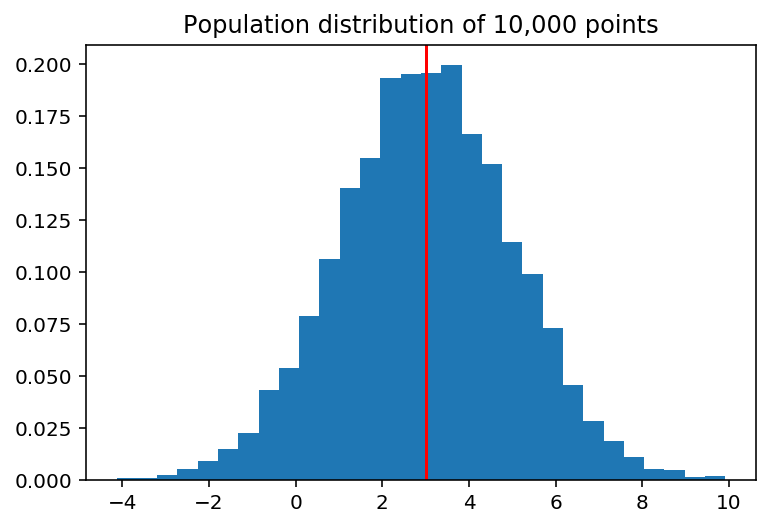

In [32]:
# Plot a histogram with 30 bins
# Giving it the argument density=True will plot normalized counts
# This will create a probability density (rather than raw counts)
plt.hist(pop, 30, density=True)
plt.axvline(mu,color='r')
plt.title('Population distribution of 10,000 points')
plt.show()

There are various ways we can describe the distribution of the dataset, beyond the standard deviation:
* Range (minimum and maximum)
* Variance ($\sigma^2$)
* Standard Error of the Mean (S.E.M., $\sigma/\sqrt{n}$)
* Confidence Intervals

We can easily get many of these descriptive statistics by using the `scipy stats` package method `describe()`. [Documentation here.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.describe.html)

>Answer Q1 on the quiz.

In [3]:
from scipy import stats

stats.describe(pop)

DescribeResult(nobs=10000, minmax=(-4.810622375979458, 10.694330238186478), mean=2.9905245064668518, variance=3.951569773483978, skewness=0.0022229447942342306, kurtosis=-0.0045301503059094195)

We created a normal distribution from a mean of 3 but with limited data points, so these values are *just* slightly off from what we would expect.

>Answer Q2 on the quiz.


Our variable `pop` is the "ground truth" population. However, we'll rarely have *10,000* datapoints in our sample. So, let's generate a more realistic sample, and see how the mean compares.

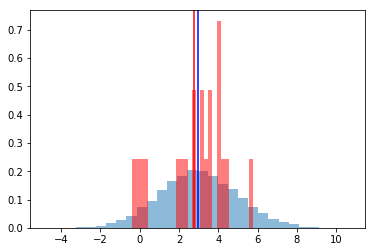

In [4]:
# Create a sample distribution with less data points
sample_mean, sample_sigma = 3, 2
sample = np.random.normal(sample_mean, sample_sigma, 20)

# Plot our histogram, with alpha to 0.5 which will make the chart slightly transparent
plt.hist(pop, 30, alpha=0.5, density=True)
plt.hist(sample, 30, alpha=0.5, color='r',density=True)
plt.axvline(np.mean(pop),color='blue') # Take the mean and plot a vertical blue line 
plt.axvline(np.mean(sample),color='red') # Take the mean and plot a vertical red line 
plt.show()

In [5]:
# Look at the descriptive statistics of our sample
print(stats.describe(sample))

DescribeResult(nobs=20, minmax=(-0.39049641640873967, 5.755214401335305), mean=2.773011550609243, variance=2.7682806898951067, skewness=-0.5690947363035833, kurtosis=-0.44791227914061205)


>Answer Q3 on the quiz.


<a id="two"></a>
## Part Two: The Central Limit Theorem

With fewer samples, the mean of the sample distribution tends to be further from the mean of the population distribution. This is known as the **central limit theorem**, which states that the distribution of sample means will become increasingly close to a normal distribution as the sample size increases, regardless of the shape of the population distribution.

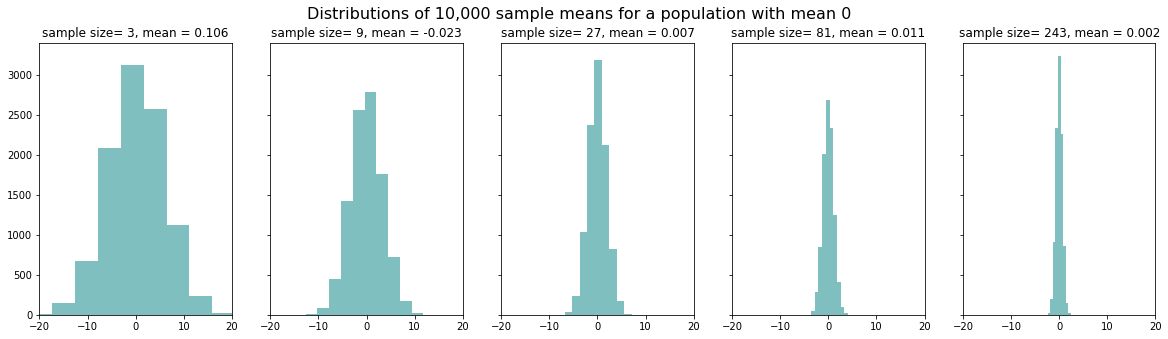

In [6]:
fig,ax = plt.subplots(1,5,figsize=(20,5),sharey=True)

mu = 0

sample_means = []

# For each subplot, create a plot.
for a in range(len(ax)):
    
    # Make the sample size = to 3^(a+1)
    sample_size = 3**(a+1)
    
    # Calculate the mean of sample of sample_size designated above, 10000 times
    for x in range(10000):
        sample_dist = np.random.normal(mu, 10, sample_size) # Create a normal distribution with mu, sigma
        sample_means.append(np.mean(sample_dist)) # Append the mean of this distribution
        
    ax[a].hist(sample_means,color='teal',alpha = .5) # Plot the distribution of means
    ax[a].set_title('sample size= '+ str(sample_size)+', mean = '+ str(np.round(np.mean(sample_means),3)))
    ax[a].set_xlim([-20,20])
    sample_means = [] # Reset the sample means

plt.suptitle('Distributions of 10,000 sample means for a population with mean '+str(mu),fontsize=16)

plt.show()

<a id="three"></a>
## Part Three: Skewed Distributions

However, not every population in nature is **normally distributed**. In fact, most populations are slightly skewed. Let's demonstrate a population distribution and sample distribution that is drawn from a [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution).

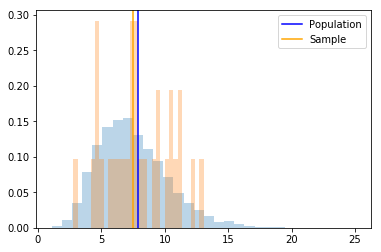

In [7]:
# Create a skewed distribution of 10,000 points with our given mu & sigma
pop_size = 10000
sample_size = 30

skewed_pop = np.random.gamma(7.5,1,pop_size)
skewed_sample = np.random.gamma(7.5,1,sample_size)

pop_stats = stats.describe(skewed_sample)
sample_stats = stats.describe(skewed_pop)

plt.hist(skewed_pop, 30, alpha = .3, density=True)
plt.hist(skewed_sample, 30, alpha = .3, density=True)
plt.axvline(pop_stats.mean,color='blue')
plt.axvline(sample_stats.mean,color='orange')
plt.legend(['Population','Sample'])

plt.show()

You might notice that with this skewed population, the mean is a pretty poor descriptor of both distributions. **When the skew is bad (*statistically bad*), we should report the median.**

><b>Task</b>: Rework our demonstration of the central limit theorem for a skewed, rather than a normal, population. Does the theorem still hold? Answer Q4 on the quiz.

### Important notes:
* <code>stats.describe()</code> doesn't give us the median (annoyingly) but `np.medium()` can!
* The `stats.skewtest()` method ([documentation here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewtest.html#scipy.stats.skewtest)) implements the <a href="https://www.jstor.org/stable/2684359?seq=1">D'Agostino-Pearson skewness test</a>, one of many different tests (e.g., the Kolmogorov-Smirov test) that can be used to check the normality of a distribution.
    * This code can return a statistic as well as a pvalue, if you designate it.
* The Kolmogorov-Smirov implementation (`stats.kstest()`) isn't as straightforward, but is also possible. It's also necessary to use the KS test for 5 or fewer points.

### Test statistical differences in rheobase

In [27]:
import pandas as pd
data = pd.read_csv('mouse_cell_metrics.csv')
spiny_data = data[data['dendrite_type']=='spiny']
aspiny_data = data[data['dendrite_type']=='aspiny']

spiny_data.head()

,cell_surface_area,dendrite_type,rheobase,input_resistance,tau
4,298.096557,spiny,30.000002,338.629120,35.177373
26,652.363854,spiny,190.000000,123.666160,20.652134
60,360.609316,spiny,150.000000,141.496464,13.239549
84,507.314114,spiny,170.000000,106.738512,14.646495
127,641.059294,spiny,130.000000,342.799552,15.623113


First, we need to know if our data is skewed or not. Let's use `skewtest` to test. If the skew test gives us a p-value of less than 0.05, the population is skewed.

>*Task*: Use the cell below to check the skew of both the aspiny and spiny rheobase data.

The skewtest p-value is 0.30233092765886504516


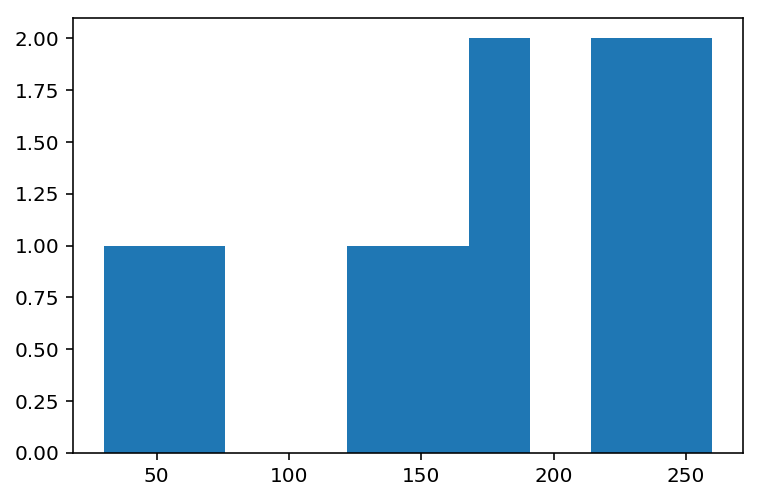

In [39]:
sample = spiny_data['rheobase']
stat,pvalue = stats.skewtest(sample)
print('The skewtest p-value is ' + '%.20f' % pvalue)
plt.hist(sample)
plt.show()

<a id="four"></a>
## Part Four: Hypothesis Testing

**Inferential statistics** generalize from observed data to the world at large


Most often, the goal of our hypothesis testing is to test whether or not two distributions are different, or if a distribution has a different mean than the underlying population distribution.

With the normal sample population we generated above, our **null hypothesis** is that the mean of our sample distribution is equal to 3. We want to test the probability that this is not true. Since we know our distributions are normal (they're generated from a normal distribution!) we can use **parametric statistics** to test our hypothesis.

The SciPy stats package has [many hypothesis testing tools](https://docs.scipy.org/doc/scipy/reference/stats.html) (see Statistical Tests). First, we can use a one-way t-test to ask whether our population has a mean different than three.

In [ ]:
sample_mean, sample_sigma = 3, 2
sample_pop = np.random.normal(sample_mean, sample_sigma, 20)
stats.ttest_1samp(sample_pop,3)

Not surprisingly, if we create a normal distribution of mean 3, the distribution is not likely to be different than 3. However, what happens if we change the mean, standard deviation, or sample size?

In most cases, we will be testing whether or not two distributions are different from eachother. In order to do so, we can use the independent t-test in our stats package: `stats.ttest_ind()`. If we had paired samples, we would use a dependent t-test [as seen here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html#scipy.stats.ttest_rel).

In [ ]:
# Create two distributions and test whether they're different
pop_1 = np.random.normal(3,2,20)
pop_2 = np.random.normal(5,2,20)
stats.ttest_ind(pop_1,pop_2)

If one of our populations is skewed, however, we **cannot use a t-test**. A t-test assumes that the populations are normally distributed. For skewed populations, we can use either the [Mann-Whitney U](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#scipy.stats.mannwhitneyu) (for independent samples, `stats.mannwhitneyu()`) or the [Wilcoxon Signed Rank Test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html#scipy.stats.wilcoxon) (for dependent/paired samples,`stats.wilcoxon()`).

In [ ]:
skewed_pop = np.random.gamma(7.5,1,10000)
comparison_pop = np.random.normal(8,2,20)

print(stats.ttest_ind(skewed_pop,comparison_pop))
print(stats.mannwhitneyu(skewed_pop,comparison_pop))

<a id="refs"></a>
## References & resources
I *strongly* recommend reading the [Points of significance](https://www.nature.com/collections/qghhqm/pointsofsignificance) series from *Nature* which covers many of these topics. This lecture specifically focuses on [The Importance of Being Uncertain](https://www.nature.com/articles/nmeth.2613).

For a demonstration on how to animate the central limit theorem, see [this Github notebook](https://github.com/rohanjoseph93/Central-Limit-Theorem/blob/master/Central%20Limit%20Theorem.ipynb).

Consider working through the examples in [Inferential thinking](https://www.inferentialthinking.com/chapters/11/Testing_Hypotheses.html).

This notebook borrows code from [Hypothesis tests in Python](https://datasciencechalktalk.com/2019/09/02/hypothesis-tests-with-python/) by Valentina Alto and ideas from a variety of other sources, including [Towards Data Science](https://towardsdatascience.com/hypothesis-testing-in-machine-learning-using-python-a0dc89e169ce).